In [187]:
### Housekeeping ###
import os

### Data ###
import numpy as np
import pandas as pd
import scipy.io

### Visualization ###
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### Machine Learning ###
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Statistics ###
import scipy.stats as stats
import statsmodels.stats.multitest as smm

### RNA-Seq ###
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

import gseapy as gp
from gseapy.plot import gseaplot

from sanbomics.tools import id_map
from sanbomics.plots import volcano

In [146]:
dir = os.path.join('..', 'data', 'E-GEOD-60052-raw-counts.tsv')
df = pd.read_csv(dir, sep='\t')
df

,Gene ID,Gene Name,SRR1797218,SRR1797219,SRR1797220,SRR1797221,SRR1797222,SRR1797223,SRR1797224,SRR1797225,...,SRR1797294,SRR1797295,SRR1797296,SRR1797297,SRR1797298,SRR1797299,SRR1797300,SRR1797301,SRR1797302,SRR1797303
0,ENSG00000000003,TSPAN6,99,33,14,14,48,104,174,16,...,71,16,7,87,46,85,42,49,109,2
1,ENSG00000000005,TNMD,51,2,26,13,0,12,0,0,...,18,1,0,0,2,58,85,4,0,23
2,ENSG00000000419,DPM1,33,52,11,0,12,109,104,2,...,16,3,11,114,53,147,18,121,66,11
3,ENSG00000000457,SCYL3,67,141,45,23,183,81,193,62,...,74,65,24,492,154,117,18,167,27,57
4,ENSG00000000460,C1orf112,39,110,28,52,53,154,71,57,...,121,32,11,324,173,127,41,224,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65212,ENSG00000281918,NaN,0,0,6,0,6,1,0,0,...,9,28,0,19,13,12,0,32,0,0
65213,ENSG00000281919,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65214,ENSG00000281920,NaN,0,0,0,1,5,0,0,0,...,36,2,0,0,17,3,0,0,0,0
65215,ENSG00000281921,NaN,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,0


In [147]:
df = df.loc[:,~df.columns.duplicated()].copy()
df

,Gene ID,Gene Name,SRR1797218,SRR1797219,SRR1797220,SRR1797221,SRR1797222,SRR1797223,SRR1797224,SRR1797225,...,SRR1797294,SRR1797295,SRR1797296,SRR1797297,SRR1797298,SRR1797299,SRR1797300,SRR1797301,SRR1797302,SRR1797303
0,ENSG00000000003,TSPAN6,99,33,14,14,48,104,174,16,...,71,16,7,87,46,85,42,49,109,2
1,ENSG00000000005,TNMD,51,2,26,13,0,12,0,0,...,18,1,0,0,2,58,85,4,0,23
2,ENSG00000000419,DPM1,33,52,11,0,12,109,104,2,...,16,3,11,114,53,147,18,121,66,11
3,ENSG00000000457,SCYL3,67,141,45,23,183,81,193,62,...,74,65,24,492,154,117,18,167,27,57
4,ENSG00000000460,C1orf112,39,110,28,52,53,154,71,57,...,121,32,11,324,173,127,41,224,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65212,ENSG00000281918,NaN,0,0,6,0,6,1,0,0,...,9,28,0,19,13,12,0,32,0,0
65213,ENSG00000281919,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65214,ENSG00000281920,NaN,0,0,0,1,5,0,0,0,...,36,2,0,0,17,3,0,0,0,0
65215,ENSG00000281921,NaN,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,0


In [148]:
meta_dir = os.path.join('..', 'data', 'E-GEOD-60052-experiment-design.tsv')
meta_df = pd.read_csv(meta_dir, sep='\t')
meta_df

,Run,Sample Characteristic[age],Sample Characteristic Ontology Term[age],Sample Characteristic[clinical information],Sample Characteristic Ontology Term[clinical information],Sample Characteristic[disease],Sample Characteristic Ontology Term[disease],Sample Characteristic[ethnic group],Sample Characteristic Ontology Term[ethnic group],Sample Characteristic[individual],Sample Characteristic Ontology Term[individual],Sample Characteristic[organism],Sample Characteristic Ontology Term[organism],Sample Characteristic[organism part],Sample Characteristic Ontology Term[organism part],Sample Characteristic[sex],Sample Characteristic Ontology Term[sex],Factor Value[disease],Factor Value Ontology Term[disease],Analysed
0,SRR1797218,66.0,NaN,smoker,NaN,normal,http://purl.obolibrary.org/obo/PATO_0000461,Chinese,http://purl.obolibrary.org/obo/HANCESTRO_0021,B08-3483,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,lung,http://purl.obolibrary.org/obo/UBERON_0002048,male,http://purl.obolibrary.org/obo/PATO_0000384,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes
1,SRR1797219,70.0,NaN,smoker,NaN,normal,http://purl.obolibrary.org/obo/PATO_0000461,Chinese,http://purl.obolibrary.org/obo/HANCESTRO_0021,B08-3758,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,lung,http://purl.obolibrary.org/obo/UBERON_0002048,male,http://purl.obolibrary.org/obo/PATO_0000384,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes
2,SRR1797220,45.0,NaN,smoker,NaN,normal,http://purl.obolibrary.org/obo/PATO_0000461,Chinese,http://purl.obolibrary.org/obo/HANCESTRO_0021,B08-4386,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,lung,http://purl.obolibrary.org/obo/UBERON_0002048,male,http://purl.obolibrary.org/obo/PATO_0000384,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes
3,SRR1797221,52.0,NaN,non-smoker,NaN,normal,http://purl.obolibrary.org/obo/PATO_0000461,Chinese,http://purl.obolibrary.org/obo/HANCESTRO_0021,B08-4579,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,lung,http://purl.obolibrary.org/obo/UBERON_0002048,female,http://purl.obolibrary.org/obo/PATO_0000383,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes
4,SRR1797222,51.0,NaN,smoker,NaN,normal,http://purl.obolibrary.org/obo/PATO_0000461,Chinese,http://purl.obolibrary.org/obo/HANCESTRO_0021,B08-4497,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,lung,http://purl.obolibrary.org/obo/UBERON_0002048,male,http://purl.obolibrary.org/obo/PATO_0000384,normal,http://purl.obolibrary.org/obo/PATO_0000461,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,SRR1797299,55.0,NaN,smoker,NaN,small cell lung carcinoma,http://www.ebi.ac.uk/efo/EFO_0000702,Chinese,http://purl.obolibrary.org/obo/HANCESTRO_0021,B10-5656,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,lung,http://purl.obolibrary.org/obo/UBERON_0002048,male,http://purl.obolibrary.org/obo/PATO_0000384,small cell lung carcinoma,http://www.ebi.ac.uk/efo/EFO_0000702,Yes
82,SRR1797300,NaN,NaN,NaN,NaN,small cell lung carcinoma,http://www.ebi.ac.uk/efo/EFO_0000702,NaN,NaN,B11-4067,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,lung,http://purl.obolibrary.org/obo/UBERON_0002048,NaN,NaN,small cell lung carcinoma,http://www.ebi.ac.uk/efo/EFO_0000702,Yes
83,SRR1797301,58.0,NaN,smoker,NaN,small cell lung carcinoma,http://www.ebi.ac.uk/efo/EFO_0000702,Chinese,http://purl.obolibrary.org/obo/HANCESTRO_0021,B11-548,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,lung,http://purl.obolibrary.org/obo/UBERON_0002048,male,http://purl.obolibrary.org/obo/PATO_0000384,small cell lung carcinoma,http://www.ebi.ac.uk/efo/EFO_0000702,Yes
84,SRR1797302,NaN,NaN,NaN,NaN,small cell lung carcinoma,http://www.ebi.ac.uk/efo/EFO_0000702,NaN,NaN,B12-1866,NaN,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,lung,http://purl.obolibrary.org/obo/UBERON_0002048,NaN,NaN,small cell lung carcinoma,http://www.ebi.ac.uk/efo/EFO_

In [149]:
meta_df = meta_df[['Run', 'Sample Characteristic[disease]']].rename(columns={'Sample Characteristic[disease]': 'condition'})
meta_df.set_index('Run', inplace=True)
meta_df.index.name = None
meta_df

,condition
SRR1797218,normal
SRR1797219,normal
SRR1797220,normal
SRR1797221,normal
SRR1797222,normal
...,...
SRR1797299,small cell lung carcinoma
SRR1797300,small cell lung carcinoma
SRR1797301,small cell lung carcinoma
SRR1797302,small cell lung carcinoma


In [150]:
df.drop(columns=['Gene Name'], inplace=True)
df

,Gene ID,SRR1797218,SRR1797219,SRR1797220,SRR1797221,SRR1797222,SRR1797223,SRR1797224,SRR1797225,SRR1797226,...,SRR1797294,SRR1797295,SRR1797296,SRR1797297,SRR1797298,SRR1797299,SRR1797300,SRR1797301,SRR1797302,SRR1797303
0,ENSG00000000003,99,33,14,14,48,104,174,16,7,...,71,16,7,87,46,85,42,49,109,2
1,ENSG00000000005,51,2,26,13,0,12,0,0,0,...,18,1,0,0,2,58,85,4,0,23
2,ENSG00000000419,33,52,11,0,12,109,104,2,0,...,16,3,11,114,53,147,18,121,66,11
3,ENSG00000000457,67,141,45,23,183,81,193,62,5,...,74,65,24,492,154,117,18,167,27,57
4,ENSG00000000460,39,110,28,52,53,154,71,57,0,...,121,32,11,324,173,127,41,224,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65212,ENSG00000281918,0,0,6,0,6,1,0,0,49,...,9,28,0,19,13,12,0,32,0,0
65213,ENSG00000281919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65214,ENSG00000281920,0,0,0,1,5,0,0,0,0,...,36,2,0,0,17,3,0,0,0,0
65215,ENSG00000281921,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,0


In [151]:
df.set_index('Gene ID', inplace=True)
df

,SRR1797218,SRR1797219,SRR1797220,SRR1797221,SRR1797222,SRR1797223,SRR1797224,SRR1797225,SRR1797226,SRR1797227,...,SRR1797294,SRR1797295,SRR1797296,SRR1797297,SRR1797298,SRR1797299,SRR1797300,SRR1797301,SRR1797302,SRR1797303
Gene ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,99,33,14,14,48,104,174,16,7,269,...,71,16,7,87,46,85,42,49,109,2
ENSG00000000005,51,2,26,13,0,12,0,0,0,0,...,18,1,0,0,2,58,85,4,0,23
ENSG00000000419,33,52,11,0,12,109,104,2,0,67,...,16,3,11,114,53,147,18,121,66,11
ENSG00000000457,67,141,45,23,183,81,193,62,5,186,...,74,65,24,492,154,117,18,167,27,57
ENSG00000000460,39,110,28,52,53,154,71,57,0,252,...,121,32,11,324,173,127,41,224,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281918,0,0,6,0,6,1,0,0,49,4,...,9,28,0,19,13,12,0,32,0,0
ENSG00000281919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000281920,0,0,0,1,5,0,0,0,0,0,...,36,2,0,0,17,3,0,0,0,0


In [152]:
df.index.name = None
df = df.T
df

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281913,ENSG00000281914,ENSG00000281915,ENSG00000281916,ENSG00000281917,ENSG00000281918,ENSG00000281919,ENSG00000281920,ENSG00000281921,ENSG00000281922
SRR1797218,99,51,33,67,39,128,597,20,171,153,...,0,0,0,0,0,0,0,0,0,0
SRR1797219,33,2,52,141,110,419,454,57,198,155,...,0,0,0,0,0,0,0,0,0,0
SRR1797220,14,26,11,45,28,197,473,17,90,147,...,0,0,0,0,0,6,0,0,0,0
SRR1797221,14,13,0,23,52,76,65,14,30,11,...,0,0,0,0,0,0,0,1,0,0
SRR1797222,48,0,12,183,53,314,134,60,299,133,...,0,0,0,0,0,6,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR1797299,85,58,147,117,127,0,222,196,221,642,...,0,0,0,0,0,12,0,3,0,0
SRR1797300,42,85,18,18,41,241,756,9,195,184,...,0,0,0,0,0,0,0,0,0,0
SRR1797301,49,4,121,167,224,47,466,57,444,266,...,0,0,0,0,0,32,0,0,0,0
SRR1797302,109,0,66,27,100,139,583,70,139,212,...,0,0,0,0,0,0,0,0,0,0


In [153]:
genes_to_keep = df.columns[df.sum(axis=0) >= 10]
len(genes_to_keep)

56016

In [154]:
filtered_df = df[genes_to_keep]
filtered_df

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281905,ENSG00000281909,ENSG00000281910,ENSG00000281912,ENSG00000281918,ENSG00000281920,ENSG00000281921
SRR1797218,99,51,33,67,39,128,597,20,171,153,...,6,9,6,0,0,0,1,0,0,0
SRR1797219,33,2,52,141,110,419,454,57,198,155,...,79,15,31,0,2,25,0,0,0,0
SRR1797220,14,26,11,45,28,197,473,17,90,147,...,15,0,9,0,0,0,0,6,0,0
SRR1797221,14,13,0,23,52,76,65,14,30,11,...,13,0,135,0,0,0,0,0,1,0
SRR1797222,48,0,12,183,53,314,134,60,299,133,...,65,0,38,0,0,7,0,6,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR1797299,85,58,147,117,127,0,222,196,221,642,...,19,0,37,0,0,6,26,12,3,0
SRR1797300,42,85,18,18,41,241,756,9,195,184,...,15,3,3,0,0,2,0,0,0,0
SRR1797301,49,4,121,167,224,47,466,57,444,266,...,46,0,75,0,2,0,13,32,0,0
SRR1797302,109,0,66,27,100,139,583,70,139,212,...,24,0,75,0,0,0,0,0,0,0


In [155]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=df,
    metadata=meta_df,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)

In [39]:
dds

AnnData object with n_obs × n_vars = 86 × 65217
    obs: 'condition'
    obsm: 'design_matrix'

In [156]:
dds.deseq2()

Fitting size factors...
... done in 0.09 seconds.

Fitting dispersions...
... done in 4.14 seconds.

Fitting dispersion trend curve...
... done in 1.13 seconds.

Fitting MAP dispersions...
... done in 4.43 seconds.

Fitting LFCs...
... done in 3.47 seconds.

Refitting 3111 outliers.

Fitting dispersions...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 0.25 seconds.

Fitting LFCs...
... done in 0.35 seconds.

/Users/ninaadkalla/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pydeseq2/dds.py:1019: ImplicitModificationWarning: Setting element `.varm['_normed_means']` of view, initializing view as actual.
  self[:, self.new_all_zeroes_genes].varm["_normed_means"] = np.zeros(
/Users/ninaadkalla/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pydeseq2/dds.py:1022: ImplicitModificationWarning: Setting element `.varm['LFC']` of view, initializing view as actual.
  self[:, self.new_all_zeroes_genes].varm["LFC"] = np.zeros(


In [41]:
dds

AnnData object with n_obs × n_vars = 86 × 65217
    obs: 'condition'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'

In [157]:
stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition small cell lung carcinoma vs normal
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000000003   50.068813        0.186334  0.412251  0.451991  0.651276   
ENSG00000000005    6.722537       -1.378788  1.111712 -1.240239  0.214887   
ENSG00000000419   38.271571        0.624634  0.422328  1.479025  0.139134   
ENSG00000000457  106.323251        0.600443  0.258667  2.321295  0.020271   
ENSG00000000460  122.884403        1.117855  0.351354  3.181562  0.001465   
...                     ...             ...       ...       ...       ...   
ENSG00000281918    7.537101        2.352306  0.964029  2.440079  0.014684   
ENSG00000281919    0.000000             NaN       NaN       NaN       NaN   
ENSG00000281920    9.557405        3.829074  1.430825  2.676129  0.007448   
ENSG00000281921    0.719867        2.229193  3.400970  0.655458  0.512173   
ENSG00000281922    0.000000             NaN       NaN       NaN      

... done in 1.71 seconds.



In [158]:
results = stat_res.results_df
results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003,50.068813,0.186334,0.412251,0.451991,0.651276,0.815979
ENSG00000000005,6.722537,-1.378788,1.111712,-1.240239,0.214887,0.422666
ENSG00000000419,38.271571,0.624634,0.422328,1.479025,0.139134,0.319629
ENSG00000000457,106.323251,0.600443,0.258667,2.321295,0.020271,0.087005
ENSG00000000460,122.884403,1.117855,0.351354,3.181562,0.001465,0.013681
...,...,...,...,...,...,...
ENSG00000281918,7.537101,2.352306,0.964029,2.440079,0.014684,0.069911
ENSG00000281919,0.000000,NaN,NaN,NaN,NaN,NaN
ENSG00000281920,9.557405,3.829074,1.430825,2.676129,0.007448,0.043905
ENSG00000281921,0.719867,2.229193,3.400970,0.655458,0.512173,NaN


In [159]:
results = results[(results['padj'] < 0.05)]
results = results[(abs(results['log2FoldChange']) > 0.05)]
results = results[(results['baseMean'] > 20)]
results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000460,122.884403,1.117855,0.351354,3.181562,0.001465,0.013681
ENSG00000000938,55.528507,-2.368954,0.576093,-4.112105,0.000039,0.000900
ENSG00000001460,86.443931,1.000003,0.338278,2.956154,0.003115,0.023684
ENSG00000002079,49.771122,1.938114,0.675608,2.868698,0.004122,0.028888
ENSG00000002586,205.021743,-1.877996,0.489489,-3.836647,0.000125,0.002217
...,...,...,...,...,...,...
ENSG00000280783,26.814512,1.791200,0.519264,3.449501,0.000562,0.006823
ENSG00000280798,175.706382,0.808593,0.276039,2.929269,0.003398,0.025166
ENSG00000281332,177.999021,0.975662,0.292882,3.331246,0.000865,0.009264
ENSG00000281392,2091.780524,1.252806,0.476021,2.631827,0.008493,0.047939


In [160]:
results.sort_values(by=['log2FoldChange'], ascending=False, inplace=True)
results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000233615,27.615679,7.679569,1.482099,5.181550,2.200499e-07,1.581557e-05
ENSG00000228810,32.590847,7.503462,1.215853,6.171359,6.770569e-10,1.806902e-07
ENSG00000266984,21.844447,7.330169,1.703677,4.302558,1.688376e-05,4.764404e-04
ENSG00000147689,20.423203,7.233236,1.482740,4.878289,1.070103e-06,5.649392e-05
ENSG00000105549,22.237465,6.950658,1.370182,5.072798,3.920092e-07,2.515929e-05
...,...,...,...,...,...,...
ENSG00000122852,1822.220830,-4.748982,0.898820,-5.283576,1.266862e-07,1.050671e-05
ENSG00000185303,2831.561330,-4.798173,0.906014,-5.295915,1.184220e-07,9.968003e-06
ENSG00000096088,108.757986,-4.935291,0.707069,-6.979933,2.953201e-12,2.904853e-09
ENSG00000261143,51.561853,-4.970657,0.993212,-5.004630,5.596948e-07,3.362759e-05


In [161]:
top50 = results.head(50)
bot50 = results.tail(50)
de_res = pd.concat([top50, bot50])
de_res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000233615,27.615679,7.679569,1.482099,5.181550,2.200499e-07,1.581557e-05
ENSG00000228810,32.590847,7.503462,1.215853,6.171359,6.770569e-10,1.806902e-07
ENSG00000266984,21.844447,7.330169,1.703677,4.302558,1.688376e-05,4.764404e-04
ENSG00000147689,20.423203,7.233236,1.482740,4.878289,1.070103e-06,5.649392e-05
ENSG00000105549,22.237465,6.950658,1.370182,5.072798,3.920092e-07,2.515929e-05
...,...,...,...,...,...,...
ENSG00000122852,1822.220830,-4.748982,0.898820,-5.283576,1.266862e-07,1.050671e-05
ENSG00000185303,2831.561330,-4.798173,0.906014,-5.295915,1.184220e-07,9.968003e-06
ENSG00000096088,108.757986,-4.935291,0.707069,-6.979933,2.953201e-12,2.904853e-09
ENSG00000261143,51.561853,-4.970657,0.993212,-5.004630,5.596948e-07,3.362759e-05


In [162]:
dds.layers['normed_counts']

array([[ 71.88899909,  37.03372681,  23.9629997 , ...,   0.        ,
          0.        ,   0.        ],
       [ 21.67894892,   1.31387569,  34.16076799, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.54176963,  27.0061436 ,  11.42567614, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 25.53157327,   2.08421006,  63.04735439, ...,   0.        ,
          0.        ,   0.        ],
       [110.33636141,   0.        ,  66.80917296, ...,   0.        ,
          0.        ,   0.        ],
       [  1.91799834,  22.05698096,  10.54899089, ...,   0.        ,
          0.        ,   0.        ]])

In [163]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds.layers['log1p']

array([[4.28893772, 3.63847331, 3.21739472, ..., 0.        , 0.        ,
        0.        ],
       [3.12143713, 0.83892391, 3.55993092, ..., 0.        , 0.        ,
        0.        ],
       [2.74353121, 3.3324239 , 2.51976499, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.27833547, 1.12629557, 4.15962272, ..., 0.        , 0.        ,
        0.        ],
       [4.7125559 , 0.        , 4.21669748, ..., 0.        , 0.        ,
        0.        ],
       [1.07089788, 3.13796859, 2.44659806, ..., 0.        , 0.        ,
        0.        ]])

In [164]:
dds_sigs = dds[:, de_res.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 86 × 100
    obs: 'condition'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks', 'log1p'

In [165]:
dds_sigs.obs_names

Index(['SRR1797218', 'SRR1797219', 'SRR1797220', 'SRR1797221', 'SRR1797222',
       'SRR1797223', 'SRR1797224', 'SRR1797225', 'SRR1797226', 'SRR1797227',
       'SRR1797228', 'SRR1797229', 'SRR1797230', 'SRR1797231', 'SRR1797232',
       'SRR1797233', 'SRR1797234', 'SRR1797235', 'SRR1797236', 'SRR1797237',
       'SRR1797238', 'SRR1797239', 'SRR1797240', 'SRR1797241', 'SRR1797242',
       'SRR1797243', 'SRR1797244', 'SRR1797245', 'SRR1797246', 'SRR1797247',
       'SRR1797248', 'SRR1797249', 'SRR1797250', 'SRR1797251', 'SRR1797252',
       'SRR1797253', 'SRR1797254', 'SRR1797255', 'SRR1797256', 'SRR1797257',
       'SRR1797258', 'SRR1797259', 'SRR1797260', 'SRR1797261', 'SRR1797262',
       'SRR1797263', 'SRR1797264', 'SRR1797265', 'SRR1797266', 'SRR1797267',
       'SRR1797268', 'SRR1797269', 'SRR1797270', 'SRR1797271', 'SRR1797272',
       'SRR1797273', 'SRR1797274', 'SRR1797275', 'SRR1797276', 'SRR1797277',
       'SRR1797278', 'SRR1797279', 'SRR1797280', 'SRR1797281', 'SRR1797282',

In [166]:
de_df = pd.DataFrame(dds_sigs.layers['log1p'].T,
                     index=dds_sigs.var_names,
                     columns=dds_sigs.obs_names)
de_df

,SRR1797218,SRR1797219,SRR1797220,SRR1797221,SRR1797222,SRR1797223,SRR1797224,SRR1797225,SRR1797226,SRR1797227,...,SRR1797294,SRR1797295,SRR1797296,SRR1797297,SRR1797298,SRR1797299,SRR1797300,SRR1797301,SRR1797302,SRR1797303
ENSG00000233615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.146542,0.000000,0.000000,...,4.383740,2.031962,0.000000,0.000000,3.137331,3.114104,0.000000,2.956827,0.000000,0.000000
ENSG00000228810,0.000000,0.000000,0.000000,0.000000,0.000000,0.380133,0.000000,2.698084,0.000000,3.450909,...,3.657647,0.000000,0.000000,3.159380,2.325032,3.668600,0.000000,3.777950,0.000000,0.000000
ENSG00000266984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.480628,0.000000,0.000000,...,4.264711,4.452622,1.978265,0.669402,2.162077,0.000000,0.000000,2.603079,0.000000,0.000000
ENSG00000147689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.312122,0.000000,1.708889,...,5.012510,3.361832,1.414662,0.669402,3.180863,0.363980,1.007677,1.826245,3.862076,0.000000
ENSG00000105549,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.383674,1.987329,0.000000,0.000000,...,4.405936,0.000000,0.000000,1.264556,4.840952,2.406770,0.000000,4.281988,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000122852,8.823603,10.201369,9.771139,8.701313,9.900541,8.424192,10.262053,5.991884,5.880835,0.000000,...,3.827865,7.396592,8.910830,0.000000,3.044134,5.654248,7.596814,6.672532,7.918360,7.266036
ENSG00000185303,9.256262,10.784106,10.108535,9.062530,10.338351,8.721593,10.699148,6.332578,4.958326,1.600895,...,3.560275,7.555638,9.641243,1.635100,3.565156,5.706673,7.676774,7.165688,8.728719,7.308036
ENSG00000096088,5.424215,7.410070,7.398048,6.675052,6.230596,6.155584,7.344143,3.986881,3.820752,0.000000,...,4.567721,2.330264,5.014126,0.000000,2.219397,3.053818,4.047168,3.921973,4.274695,1.756995
ENSG00000261143,5.170498,5.651777,5.758157,6.788514,6.711190,5.046441,6.417126,0.000000,4.162593,0.000000,...,3.560275,3.771055,5.546886,0.951059,1.115288,0.000000,0.000000,3.901121,2.313559,0.000000


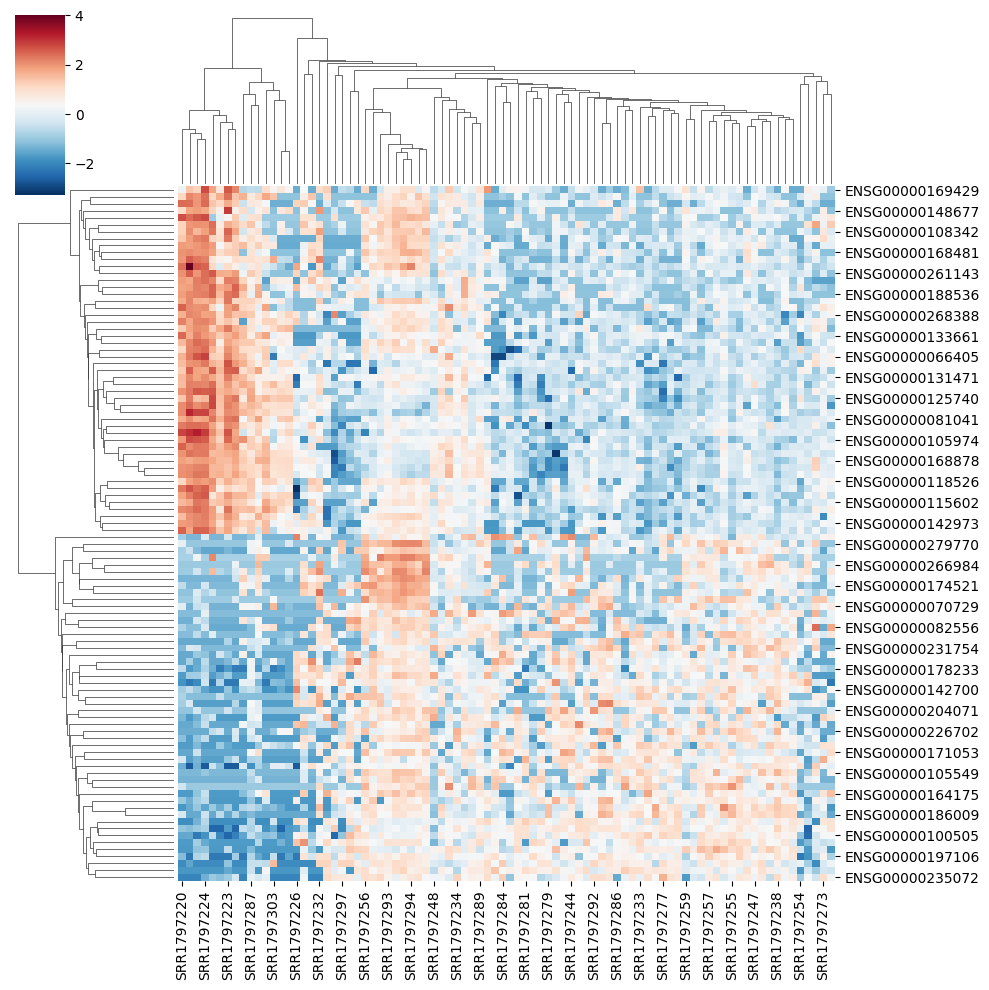

In [167]:
sns.clustermap(de_df, z_score=0, cmap='RdBu_r')

In [169]:
results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000233615,27.615679,7.679569,1.482099,5.181550,2.200499e-07,1.581557e-05
ENSG00000228810,32.590847,7.503462,1.215853,6.171359,6.770569e-10,1.806902e-07
ENSG00000266984,21.844447,7.330169,1.703677,4.302558,1.688376e-05,4.764404e-04
ENSG00000147689,20.423203,7.233236,1.482740,4.878289,1.070103e-06,5.649392e-05
ENSG00000105549,22.237465,6.950658,1.370182,5.072798,3.920092e-07,2.515929e-05
...,...,...,...,...,...,...
ENSG00000122852,1822.220830,-4.748982,0.898820,-5.283576,1.266862e-07,1.050671e-05
ENSG00000185303,2831.561330,-4.798173,0.906014,-5.295915,1.184220e-07,9.968003e-06
ENSG00000096088,108.757986,-4.935291,0.707069,-6.979933,2.953201e-12,2.904853e-09
ENSG00000261143,51.561853,-4.970657,0.993212,-5.004630,5.596948e-07,3.362759e-05


In [170]:
mapper = id_map(species='human')

In [171]:
results['symbol'] = results.index.map(mapper.mapper)
results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
ENSG00000233615,27.615679,7.679569,1.482099,5.181550,2.200499e-07,1.581557e-05,HNRNPA1P42
ENSG00000228810,32.590847,7.503462,1.215853,6.171359,6.770569e-10,1.806902e-07,PABPC1P11
ENSG00000266984,21.844447,7.330169,1.703677,4.302558,1.688376e-05,4.764404e-04,POLR3GP2
ENSG00000147689,20.423203,7.233236,1.482740,4.878289,1.070103e-06,5.649392e-05,FAM83A
ENSG00000105549,22.237465,6.950658,1.370182,5.072798,3.920092e-07,2.515929e-05,THEG
...,...,...,...,...,...,...,...
ENSG00000122852,1822.220830,-4.748982,0.898820,-5.283576,1.266862e-07,1.050671e-05,SFTPA1
ENSG00000185303,2831.561330,-4.798173,0.906014,-5.295915,1.184220e-07,9.968003e-06,SFTPA2
ENSG00000096088,108.757986,-4.935291,0.707069,-6.979933,2.953201e-12,2.904853e-09,PGC
ENSG00000261143,51.561853,-4.970657,0.993212,-5.004630,5.596948e-07,3.362759e-05,ADAMTS7P3


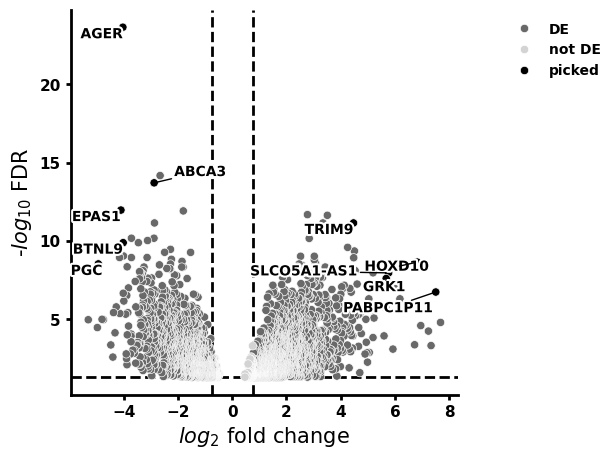

In [191]:
volcano(results, symbol='symbol')